In [1]:
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel,Field
from typing import TypedDict,List,Optional,Annotated
from utils.schema import State

In [2]:
#agent imports
from agents.universal_naming_agent import universal_name_refiner_v4
from agents.universal_parser_agent import parser_graph
from agents.comparison_agent import get_comparison_agent
from agents.db_hooks import check_doc_with_name_version,check_doc_present, archive_chunk, upsert_chunks, upsert_doc,query_doc_exists
    

d:\smart_search_fino\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\smart_search_fino\.venv\lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
def routing_to_parsing(state:State):
    revision_tag = state['revision_tag']
    if revision_tag is None:
        filename = state['base_doc_name']
        version_no = state['version']
        is_present = check_doc_with_name_version(filename,version_no)
        
        if is_present:
            return "end"
        else:
            return "parsing_agent"
    return "parsing_agent"
    

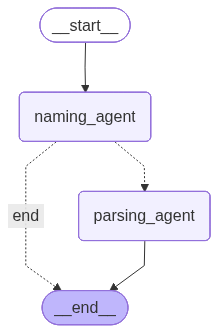

In [4]:
builder = StateGraph(State)

builder.add_node("naming_agent",universal_name_refiner_v4)
builder.add_node("parsing_agent",parser_graph)

builder.add_edge(START,"naming_agent")

builder.add_conditional_edges(
    "naming_agent",
    routing_to_parsing,
    {
        "parsing_agent":"parsing_agent",
        "end":END
    }
)

builder.add_edge("parsing_agent",END)

graph = builder.compile()

graph


In [5]:
def routing_after_parsing(state:State):
    revision_tag = state['revision_tag']
    filename = state['base_doc_name']
    version_no = state['version']
    content_hash = state.get('content_hash') # Ensure hash is in your state

    # 1. NEW: Check if this exact content is already in the system
    if content_hash and query_doc_exists(content_hash):
        print(f"Duplicate content detected for {filename}. Skipping to END.")
        return "end" # Or whatever your 'Finish' node is named
    if revision_tag is not None:
        return "compare"
    
    if check_doc_present(filename, version_no):
        return "archive_existing_chunks"
     
    return "push_all"


In [6]:
def remove_chunks(state:State):
    doc_id = state['base_doc_name']
    
    try:
        archive_chunk(doc_id)
    except Exception as e:
        print(f"Error Executing archieve Chunk: {e}")
    
    return state

In [7]:
def push_chunks(state:State):
    
    chunks = state['chunks']
    
    try:
        upsert_doc(state['base_doc_name'],state['version'],state['extraction_stats'],state['content_hash'])
        upsert_chunks(chunks)
    except Exception as e:
        print(f"Error Executing doc or chunk upsert: {e}")
    
    return state

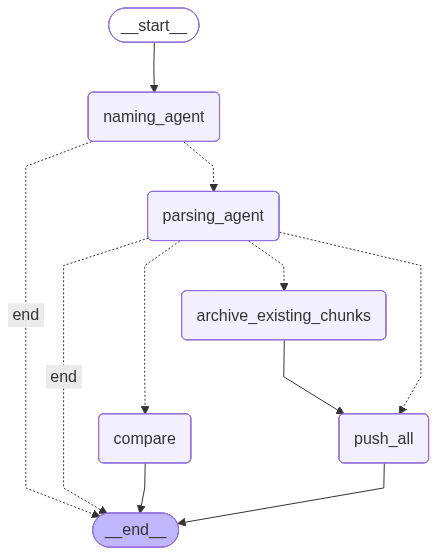

In [8]:
builder = StateGraph(State)

builder.add_node("naming_agent",universal_name_refiner_v4)
builder.add_node("parsing_agent",parser_graph)
builder.add_node("archive_existing_chunks",remove_chunks)
builder.add_node("push_all",push_chunks)
builder.add_node("compare",get_comparison_agent)

builder.add_edge(START,"naming_agent")

builder.add_conditional_edges(
    "naming_agent",
    routing_to_parsing,
    {
        "parsing_agent":"parsing_agent",
        "end":END
    }
)
builder.add_conditional_edges(
    "parsing_agent",
    routing_after_parsing,
    {
        "archive_existing_chunks":"archive_existing_chunks",
        "push_all":"push_all",
        "compare":"compare",
        "end":END
    }
)

builder.add_edge("archive_existing_chunks","push_all")
builder.add_edge("compare",END)
builder.add_edge("push_all",END)

graph = builder.compile()
graph

In [9]:
final = graph.invoke({"original_filename":"revised_Citizens Charter_v2.pdf"})
final

Consider using the pymupdf_layout package for a greatly improved page layout analysis.
Model is getting load
 Semantic chunking model (LOCAL E5): D:\hf_cache\models--intfloat--e5-large-v2\snapshots\f169b11e22de13617baa190a028a32f3493550b6
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
DB connected
Successfully upserted 17 chunks for citizens_charter
STORED 17 chunks successfully.


{'original_filename': 'revised_Citizens Charter_v2.pdf',
 'normalized_filename': 'citizens_charter_v2_revised.pdf',
 'version': 'v2',
 'revision_tag': 'revised',
 'is_collision': False,
 'confidence': 0.98,
 'version_detected': True,
 'base_doc_name': 'citizens_charter',
 'content_hash': '165671b2bc66c168dc9a9dc34f5b2ff8e2cd97bd6a9e9660c5c7c4c69e7f9306',
 'raw_text': 'Classification: Public FINO Payments Bank \n\nCitizen’s Charter === PAGE BREAK ===\n\nClassification: Public\n\nClassification: Public\n\nContents \n\n1. \nPreface .......................................................................................................................................................... 2 \n\n2. \nIntroduction and Objectives ........................................................................................................................ 2 \n\n3. \nOffered Deposit Accounts ..................................................................................................................

In [10]:
final['report']

{'total_new': 17,
 'unchanged': 0,
 'new_added': 17,
 'old_archived': 15,
 'exact_unchanged': 0,
 'fuzzy_unchanged': 0,
 'total_old': 15,
 'matched_old': 0,
 'to_archive': 15,
 'storage_savings': '0.0%',
 'action': 'sync_complete'}